## Introduction

This is the third in a series of lessons related to astronomy data.

As a continuing example, we will replicate part of the analysis in a recent paper, "[Off the beaten path: Gaia reveals GD-1 stars outside of the main stream](https://arxiv.org/abs/1805.00425)" by Adrian M. Price-Whelan and Ana Bonaca.

In the first lesson we wrote an ADQL query to collect data from the Gaia database for stars in a region where GD-1 is known to be visible.

In the second lesson, we selected stars whose proper motion is consistent with being in GD-1, in two ways: first, using a Pandas DataFrame and a Boolean Series; then, using ADQL to do the selection on the Gaia server.

The next step in the analysis is to select candidate stars based on photometry.  The following figure from the paper is a color-magnitude diagram for the stars selected based on proper motion:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-3.png">

In red is a theoretical isochrone, showing where we expect the stars in GD-1 to fall based on the metallicity and age of their original globular cluster. 

By selecting stars in the shaded area, we can further distinguish the main sequence of GD-1 from younger background stars.

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery astro-gala pyia
    !mkdir data

In [87]:
import os

filename = 'gd1_candidates.hdf5'

if not os.path.exists(filename):
    !wget https://github.com/datacarpentry/astronomy-python/raw/gh-pages/data/gd1_candidates.hdf5

## Reloading the data

Picking up where we left off, let's reload the data from the previous query.

In [3]:
import pandas as pd

filename = 'gd1_candidates.hdf5'
dataset_name = 'candidate_df'

candidate_df = pd.read_hdf(filename, dataset_name)

`candidate_df` is the Pandas DataFrame that contains the results from `query5`, which selects stars likely to be in GD-1 based on proper motion.  It also includes position and proper motion transformed to the ICRS frame.

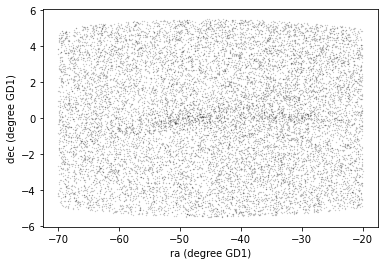

In [4]:
import matplotlib.pyplot as plt

x = candidate_df['phi1']
y = candidate_df['phi2']

plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)');

This is the same figure we saw at the end of the previous notebook.  GD-1 is visible against the background stars, but we will be able to see it more clearly after selecting based on photometry data.

## Making Figures That Tell a Story

So far the figure we've made have been "quick and dirty".  Mostly we have used Matplotlib's default style, although we have adjusted a few parameters, like `markersize` and `alpha`, to improve legibility.

Now that the analysis is done, it's time to think more about:

1. Making professional-looking figures that are ready for publication, and

2. Making figures that communicate a scientific result clearly and compellingly.

Not necessarily in that order.

Let's start by reviewing Figure 1 from the original paper.  We've seen the individual panels, but now let's look at the whole thing, along with the caption:

<img width="500" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-5.png">

**Exercise:** Think about the following questions:

1. What is the primary scientific result of this work?

2. What story is this figure telling?

3. In the design of this figure, can you identify 1-2 choices the authors made that you think are effective?  Think about big-picture elements, like the number of panels and how they are arranged, as well as details like the choice of typeface.

4. Can you identify 1-2 elements that could be improved, or that you might have done differently?

Some topics that might come up in this discussion:

1. The primary result is that the multiple stages of selection make it possible to separate likely candidates from the background more effectively than in previous work, which makes it possible to see the structure of GD-1 in "unprecedented detail".

2. The figure documents the selection process as a sequence of steps.  Reading right-to-left, top-to-bottom, we see selection based on proper motion, the results of the first selection, selection based on color and magnitude, and the results of the second selection.  So this figure documents the methodology and presents the primary result.

3. It's mostly black and white, with minimal use of color, so it will work well in print.  The annotations in the bottom left panel guide the reader to the most important results.  It contains enough technical detail for a professional audience, but most of it is also comprehensible to a more general audience.  The two left panels have the same dimensions and their axes are aligned.

4. Since the panels represent a sequence, it might be better to arrange them left-to-right.  The placement and size of the axis labels could be tweaked.  The entire figure could be a little bigger to match the width and proportion of the caption.  The top left panel has unnused white space (but that leaves space for the annotations in the bottom left).

## Multiple panels

Now let's think about replicating elements of the original figure, starting with the most prominent feature of Figure 1: it contains multiple panels, also known as "subplots".

Matplotlib provides two functions for making figures like this, confusingly called `subplot` and `subplots`.

TODO: Which one(s) are we presenting and why?

They will be easier to use if we put the code that generates each panel in a function.

To make the panel in the upper right, we have to reload `centerline`.

In [56]:
filename = 'gd1_candidates.hdf5'
dataset_name = 'centerline'

centerline = pd.read_hdf(filename, dataset_name)

And redefine the coordinates of the rectangle we selected.

In [57]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

pm1_rect = [pm1_min, pm1_min, pm1_max, pm1_max]
pm2_rect = [pm2_min, pm2_max, pm2_max, pm2_min]

To plot this rectangle, we'll use a feature we have not seen before: `Polygon`, which is provided by Matplotlib.

To create a `Polygon`, we have to put the coordinates in an array with `x` values in the first column and `y` values in the second column. 

In [58]:
vertices = np.transpose([pm1_rect, pm2_rect])
vertices

array([[-8.9, -2.2],
       [-8.9,  1. ],
       [-6.9,  1. ],
       [-6.9, -2.2]])

The following function takes a `DataFrame` as a parameter, plots the proper motion for each star, and adds a shaded `Polygon` to show the region we selected.

In [59]:
from matplotlib.patches import Polygon

def plot_proper_motion(df):
    pm1 = df['pm_phi1']
    pm2 = df['pm_phi2']

    plt.plot(pm1, pm2, 'ko', markersize=0.3, alpha=0.3)
    
    poly = Polygon(vertices, closed=True, 
                   facecolor='C1', alpha=0.4)
    plt.gca().add_patch(poly)
    
    plt.xlabel('$\mu_{\phi_1} [\mathrm{mas~yr}^{-1}]$')
    plt.ylabel('$\mu_{\phi_2} [\mathrm{mas~yr}^{-1}]$')

    plt.xlim(-12, 8)
    plt.ylim(-10, 10)

Notice that `add_patch` is like `invert_yaxis`; in order to call it, we have to use `gca` to get the current axes.

Here's what the new version of the figure looks like.  We've changed the labels on the axes to be consistent with the paper.

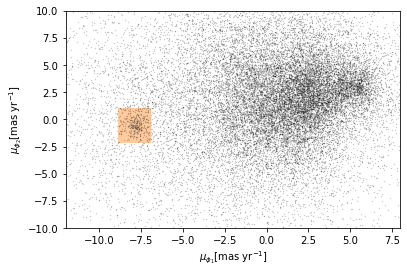

In [60]:
plot_proper_motion(centerline)

We use `add_patch` 

We already have a function that generates the color-magnitude diagram.

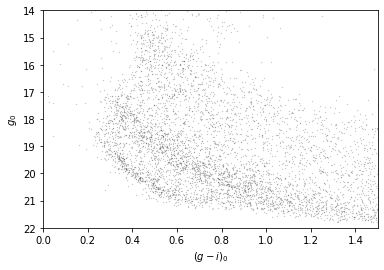

In [61]:
plot_cmd(results7)



**Exercise:** Add a few lines to the previous cell to show the Polygon we selected as a shaded area.  

Recall that the coordinates we chose for the polygon are in an array called `coords`:

In [62]:
coords

[(0.2867383512544802, 18.431199411331864),
 (0.41666666666666663, 19.38778513612951),
 (0.5689964157706092, 20.013245033112582),
 (0.7347670250896057, 20.63870493009566),
 (0.8064516129032258, 21.374540103016926),
 (0.600358422939068, 21.558498896247244),
 (0.4077060931899641, 21.043414275202355),
 (0.2777777777777778, 19.939661515820458),
 (0.17473118279569888, 19.019867549668874),
 (0.18817204301075263, 18.3944076526858)]

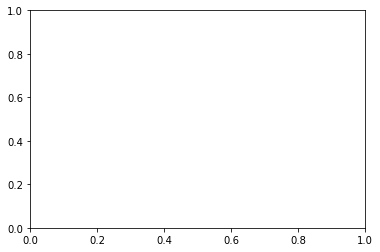

In [63]:
# Solution

poly = Polygon(coords, closed=True, 
               facecolor='C1', alpha=0.4)
plt.gca().add_patch(poly)

Now let's work on the figure in the upper left.  Here's a function that takes a `DataFrame` of candidate stars and plots their positions in GD-1 coordindates. 

In [64]:
def plot_first_selection(df):
    x = df['phi1']
    y = df['phi2']

    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    #plt.xlabel('$\phi_1$ [deg]')
    plt.ylabel('$\phi_2$ [deg]')
    plt.title('Proper motion selection', fontsize='medium')

    plt.axis('equal')

And here's what it looks like.

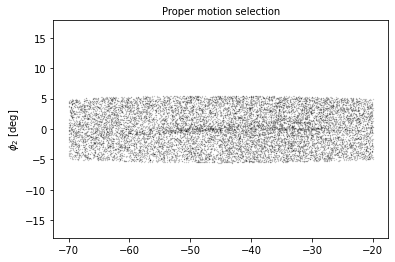

In [65]:
plot_first_selection(candidate_df)

Finally, here's a function that generates the figure in the lower left.

In [66]:
def plot_second_selection(df):
    x = df['phi1']
    y = df['phi2']

    plt.plot(x, y, 'ko', markersize=0.7, alpha=0.9)

    plt.xlabel('$\phi_1$ [deg]')
    plt.ylabel('$\phi_2$ [deg]')
    plt.title('Proper motion + photometry selection', fontsize='medium')

    plt.axis('equal')

And here's what it looks like.

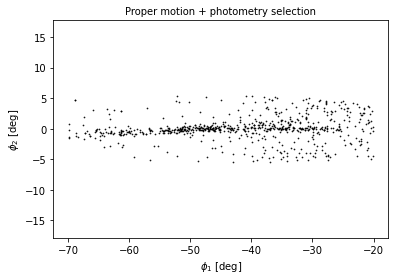

In [67]:
plot_second_selection(selected)

## Subplots

Now we're ready to put it all together.  To make a figure with four subplots, we'll use `subplot2grid`, [which requires two arguments](https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.subplot2grid.html):

* `shape`, which is a tuple with the number of rows and columns in the grid, and

* `loc`, which is a tuple identifying the location in the grid we're about to fill.

In this example, `shape` is `(2, 2)` to create two rows and two columns.

For the first panel, `loc` is `(0, 0)`, which indicates row 0 and column 0, which is the upper-left panel.

Here's how we use it to draw the four panels.

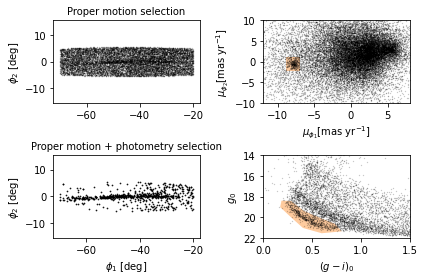

In [68]:
shape = (2, 2)
plt.subplot2grid(shape, (0, 0))
plot_first_selection(candidate_df)

plt.subplot2grid(shape, (0, 1))
plot_proper_motion(centerline)

plt.subplot2grid(shape, (1, 0))
plot_second_selection(selected)

plt.subplot2grid(shape, (1, 1))
plot_cmd(results7)
poly = Polygon(coords, closed=True, 
               facecolor='C1', alpha=0.4)
plt.gca().add_patch(poly)

plt.tight_layout()

We use [`plt.tight_layout`](https://matplotlib.org/3.3.1/tutorials/intermediate/tight_layout_guide.html) at the end, which adjusts the sizes of the panels to make sure the titles and axis labels don't overlap.

**Exercise:** See what happens if you leave out `tight_layout`.

## Adjusting proportions

For one thing, the panels are currently the same size.  To get a better view of GD-1, we'd like to stretch the panels on the left and compress the ones on the right.

To do that, we'll use the `colspan` argument to make a panel that spans multiple columns in the grid.

In the following example, `shape` is `(2, 4)`, which means 2 rows and 4 columns.

The panels on the left span three columns, so they are three times wider than the panels on the right.

At the same time, we use `figsize` to adjust the aspect ratio of the whole figure.

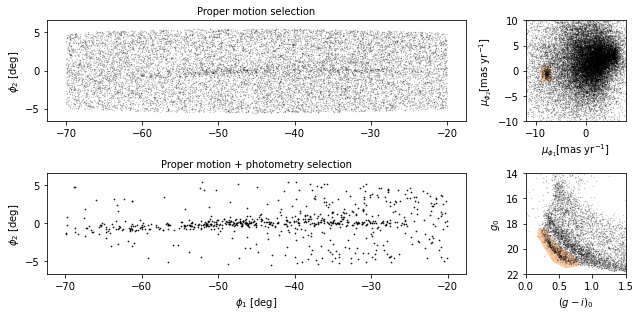

In [69]:
plt.figure(figsize=(9, 4.5))

shape = (2, 4)
plt.subplot2grid(shape, (0, 0), colspan=3)
plot_first_selection(candidate_df)

plt.subplot2grid(shape, (0, 3))
plot_proper_motion(centerline)

plt.subplot2grid(shape, (1, 0), colspan=3)
plot_second_selection(selected)

plt.subplot2grid(shape, (1, 3))
plot_cmd(results7)
poly = Polygon(coords, closed=True, 
               facecolor='C1', alpha=0.4)
plt.gca().add_patch(poly)

plt.tight_layout()

This is looking more and more like the figure in the paper.

**Exercise:** In this example, the ratio of the widths of the panels is 3:1.  How would you adjust it if you wanted the ratio to be 3:2?

## Finishing touches

The figure in the paper uses three other features to present the results more clearly and compellingly:

* A vertical dashed line to distinguish the previously undetected region of GD-1,

* A label that identifies the new region, and

* Several annotations that combine text and arrows to identify features of GD-1.

As an exercise, choose any or all of these features and add them to the figure:

* To draw vertical lines, see [`plt.vlines`](https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.vlines.html) and [`plt.axvline`](https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.axvline.html#matplotlib.pyplot.axvline).

* To add text, see [`plt.text`](https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.text.html).

* To add an annotation with text and an arrow, see [plt.annotate]().

And here is some [additional information about text and arrows](https://matplotlib.org/3.3.1/tutorials/text/annotations.html#plotting-guide-annotation).

In [79]:
# Solution

# plt.axvline(-55, ls='--', color='gray', 
#             alpha=0.4, dashes=(6,4), lw=2)
# plt.text(-60, 5.5, 'Previously\nundetected', 
#          fontsize='small', ha='right', va='top');

# arrowprops=dict(color='gray', shrink=0.05, width=1.5, 
#                 headwidth=6, headlength=8, alpha=0.4)

# plt.annotate('Spur', xy=(-33, 2), xytext=(-35, 5.5),
#              arrowprops=arrowprops,
#              fontsize='small')

# plt.annotate('Gap', xy=(-22, -1), xytext=(-25, -5.5),
#              arrowprops=arrowprops,
#              fontsize='small')

## Customization

Matplotlib provides a default style that determines things like the colors of lines, the placement of labels and ticks on the axes, and many other properties.

There are several ways to override these defaults and customize your figures:

* To customize only the current figure, you can call functions like `tick_params`, which we'll demonstrate below.

* To customize all figures in a notebook, you use `rcParams`.

* To override more than a few defaults at the same time, you can use a style sheet.

As a simple example, notice that Matplotlib puts ticks on the outside of the figures by default, and only on the left and bottom sides of the axes.

To change this behavior, you can use `gca()` to get the current axes and `tick_params` to change the settings.

Here's how you can put the ticks on the inside of the figure:

```
plt.gca().tick_params(direction='in')
```

**Exercise:** Add that line to one of the previous examples and confirm that it only affects one figure.  Then read the documentation of [`tick_params`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html) and use it to put ticks on the top and right sides of the axes.

In [80]:
# Solution

# plt.gca().tick_params(top=True, right=True)

## rcParams

If you want to make a customization that applies to all figures in a notebook, you can use `rcParams`.

Here's an example that reads the current font size from `rcParams`:

In [81]:
import matplotlib as mpl

mpl.rcParams['font.size']

14.0

And sets it to a new value:

In [82]:
mpl.rcParams['font.size'] = 14

**Exercise:** Plot the previous figure again, and see what font sizes have changed.  Look up any other element of `rcParams`, change its value, and check the effect on the figure.

If you find yourself making the same customizations in several notebooks, you can put changes to `rcParams` in a `matplotlibrc` file, [which you can read about here](https://matplotlib.org/3.3.1/tutorials/introductory/customizing.html#customizing-with-matplotlibrc-files).

## Style sheets

The `matplotlibrc` file is read when you import Matplotlib, so it is not easy to switch from one set of options to another.

The solution to this problem is style sheets, [which you can read about here](https://matplotlib.org/3.1.1/tutorials/introductory/customizing.html)

Matplotlib provides a set of predefined style sheets, or you can make your own.

The following expression is a list of style sheets installed on your system.

In [83]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

Note that `seaborn-paper`, `seaborn-talk` and `seaborn-poster` are particularly intended to prepare versions of a figure with text sizes and other features that work well in papers, talks, and posters.

To use any of these style sheets, run `plt.style.use` like this:

In [84]:
plt.style.use('fivethirtyeight')

The style sheet you choose will affect the appearance of all figures you plot after calling `use`, unless you override any of the options or call `use` again.

**Exercise:** Choose one of the styles on the list and select it by calling `use`.  Then go back and plot one of the figures above and see what effect it has.

If you can't find a style sheet that's exactly what you want, you can make your own.  This repository includes a style sheet called `az-paper-twocol.mplstyle`, with customizations chosen by Azalee Bostroem for publication in astronomy journals.

You can use it like this:

In [85]:
import os

filename = 'az-paper-twocol.mplstyle'

if not os.path.exists(filename):
    !wget https://github.com/datacarpentry/astronomy-python/raw/gh-pages/data/az-paper-twocol.mplstyle

In [86]:
plt.style.use('./az-paper-twocol.mplstyle')

The prefix `./` tells Matplotlib to look for the file in the current directory.

As an alternative, you can install a style sheet for your own use by putting it in your configuration directory.  To find out where that it, you can run the following command:

```
mpl.get_configdir()
```

## Summary